In [365]:
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from pandas.plotting import scatter_matrix
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [366]:
print(torch.version.cuda)  # Check the CUDA version PyTorch is using
print(torch.cuda.is_available())  # Check if CUDA is available
print(torch.cuda.device_count())  # Check the number of GPUs detected
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

12.4
True
1
Using device: cuda


# 1. Regression Neural Network

## 1.1 Load Data

In [367]:
# Define filepath
file_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', 'housing')
file_name = 'new_projects_data.csv'
file_name = r'D:\Github\AthenaFlora\York\IndependentResearchProject\Train\Data\remove_outlier.csv'

In [368]:
df_housing = pd.read_csv(os.path.join(file_path, file_name), sep=',', encoding='utf-8')
print(df_housing.columns)

Index(['full_total_building_area', 'long', 'lat', 'address_level', 'area_code',
       'project_main_usage', 'number_of_buildings', 'total_land_area',
       'salary', 'construction_cost', 'land_price_city',
       'land_price_com_service', 'land_price_resi', 'land_price_indus',
       'floor_area_ratio', 'period_days', 'start_date_year',
       'start_date_month', 'start_date_day', 'start_date_dayofweek',
       'end_date_year', 'end_date_month', 'end_date_day', 'end_date_dayofweek',
       'glass', 'plywood', 'stainless_steel', 'rebar', 'hot_rolled_coil',
       'rubber', 'fiberboard', 'plastic', 'copper', 'investment',
       'project_category_expansion', 'project_category_new',
       'project_category_refurbishment', 'project_category_renovation',
       'main_structure_brick_concrete', 'main_structure_frame',
       'main_structure_reinforced_concrete', 'main_structure_steel',
       'project_usage_area_residential', 'project_usage_area_commercial',
       'project_usage_area_ind

In [369]:
df_housing.head()

,full_total_building_area,long,lat,address_level,area_code,project_main_usage,number_of_buildings,total_land_area,salary,construction_cost,...,project_usage_area_supporting facilities,project_usage_area_mixed use,project_usage_area_road,project_usage_area_green land,project_usage_area_underground,project_usage_area_other,max_building_floors,min_building_floors,mean_building_floors,median_building_floors
0,16500.00,113.166705,23.462248,7,440114,industrial,1.0,4844.96,85729.0,6005.89,...,0.00,0.0,0.0,0.0,0.0,0.0,10.0,10.0,10.0,10.0
1,45618.00,113.430984,23.422396,1,440114,industrial,3.0,6623.00,85729.0,6005.89,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,73131.72,113.436605,22.937827,6,440113,industrial,4.0,16135.00,85729.0,6005.89,...,63744.49,0.0,0.0,0.0,0.0,0.0,12.0,2.0,8.0,9.0
3,18000.00,113.071181,23.391045,1,440114,industrial,1.0,7579.32,85729.0,6005.89,...,0.00,0.0,0.0,0.0,0.0,0.0,14.0,14.0,14.0,14.0
4,69000.00,113.517449,22.827258,1,440115,industrial,3.0,92500.00,85729.0,6005.89,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [370]:
# # Load csv data
# df_housing = pd.read_csv(os.path.join(file_path, file_name), sep=',', encoding='utf-8')
# # df_housing = df_housing.drop(['index','project_overview_en','project_overview_cn','structured_json','project_category',], axis=1)
# df_housing.dropna(subset=['area_code', 'project_main_usage', 'investment'], inplace=True)
# df_housing = df_housing[['full_total_building_area', 'area_code', 'lat', 'long', 'project_main_usage', 'number_of_buildings', 'total_land_area', 
#                          'floor_area_ratio', 'period_days', 'land_price','salary_avg_construction', 'hot_rolled_coil', 'end_date', 'start_date', 'investment']]

# drop_area = [440102, 440185, 440117, 440101]
# df_housing.drop(df_housing[df_housing['area_code'].isin(drop_area)].index, inplace=True)

# drop_usage = ['green land', 'road', 'underground', 'other']
# df_housing.drop(df_housing[df_housing['project_main_usage'].isin(drop_usage)].index, inplace=True)

# df_housing.loc[df_housing['floor_area_ratio'] > 100, 'floor_area_ratio'] = None
# # Replace None in floor_area_ratio with full_total_building_area / total_land_area where possible
# df_housing.loc[(df_housing['floor_area_ratio'].isna()) & 
#                (df_housing['full_total_building_area'].notna()) & 
#                (df_housing['total_land_area'].notna()), 'floor_area_ratio'] = df_housing.apply(
#     lambda row: row['full_total_building_area'] / row['total_land_area'] if row['full_total_building_area'] / row['total_land_area'] < 15 else None, axis=1)

# df_housing.loc[(
#     (df_housing['full_total_building_area'] < 3000) &
#     df_housing['number_of_buildings'].isna()), 'number_of_buildings'] = 1

# # remove outliers for investment / full_total_building_area > 3000
# # check values of investment / full_total_building_area
# # plot values of investment / full_total_building_area
# # plt.scatter(df_housing['investment'] / df_housing['full_total_building_area']*10000, df_housing['investment'])
# print(df_housing['investment'].describe())
# # df_housing = df_housing[df_housing['investment'] / df_housing['full_total_building_area'] < 2000] 
# df_housing = df_housing[df_housing['investment'] < 50000] 
# df_housing = df_housing[df_housing['investment'] > 1000]

# # # for usage in df_housing['area_code'].unique():
# # #     print(usage)
# # #     print(df_housing[df_housing['area_code'] == usage].shape)
# print(len(df_housing))
# df_housing.head()

# # df_housing.to_csv(os.path.join(file_path, 'cleaned_data.csv'), index=False)

In [371]:
# Create features (X) and labels (y) 
X, y = df_housing.drop('investment', axis=1), df_housing[['investment']]

## 1.2 Train / Test / Validation Split

In [372]:
# Create train and test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=X.project_main_usage,
                                                    random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# check X_test's project_main_usage distribution
# print(X_test['project_main_usage'].value_counts())

(2989, 55) (1282, 55) (2989, 1) (1282, 1)


In [373]:
# Drop 'project_main_usage' column before transforming the data
X_train = X_train.drop(['project_main_usage'], axis=1)
X_test = X_test.drop(['project_main_usage'], axis=1)

In [374]:
# Create test and validation split
X_test, X_val, y_test, y_val = train_test_split(X_test,
                                                y_test,
                                                test_size=0.5,
                                                random_state=42)
print(X_test.shape, X_val.shape, y_test.shape, y_val.shape)

(641, 54) (641, 54) (641, 1) (641, 1)


In [375]:
print(X_train.columns)

Index(['full_total_building_area', 'long', 'lat', 'address_level', 'area_code',
       'number_of_buildings', 'total_land_area', 'salary', 'construction_cost',
       'land_price_city', 'land_price_com_service', 'land_price_resi',
       'land_price_indus', 'floor_area_ratio', 'period_days',
       'start_date_year', 'start_date_month', 'start_date_day',
       'start_date_dayofweek', 'end_date_year', 'end_date_month',
       'end_date_day', 'end_date_dayofweek', 'glass', 'plywood',
       'stainless_steel', 'rebar', 'hot_rolled_coil', 'rubber', 'fiberboard',
       'plastic', 'copper', 'project_category_expansion',
       'project_category_new', 'project_category_refurbishment',
       'project_category_renovation', 'main_structure_brick_concrete',
       'main_structure_frame', 'main_structure_reinforced_concrete',
       'main_structure_steel', 'project_usage_area_residential',
       'project_usage_area_commercial', 'project_usage_area_industrial',
       'project_usage_area_public

In [376]:
for col in X_train.columns:
    print(col)
    print(X_train[col].unique())

full_total_building_area
[12827.  31598.  12363.  ... 16930.6 15500.  40061.5]
long
[113.563323 113.44347  113.607346 ... 113.507105 113.549033 113.550137]
lat
[23.195031 22.87524  23.556788 ... 23.444449 22.802275 23.204151]
address_level
[ 8  1 -1  4  5  6  7  3 10  9  2]
area_code
[440116 440113 440184 440103 440111 440183 440112 440114 440118 440106
 440115 440104 440105]
number_of_buildings
[  3.   1.   2.   7.   5.   4.   6.  10.  18.   9.  59.  33.   8.  23.
  12.  60.  11.  19.  34.  26.  15.  16.  20. 112.  21.  73.  39.  14.
  13.  40.  62.  63.  52.  42.  48. 130.  27. 110.  37.  74.  36.  43.
  31.  35.  29. 151.  49.  89.  17.  28. 640.  22. 100.]
total_land_area
[20991.62  18329.476  6394.6   ... 28866.81  18234.65  32363.366]
salary
[33734. 29347. 26158. 61743. 71493. 56796. 39781. 78409. 44152. 85729.
 66934. 81755. 76064. 53964. 48288. 23334. 20867. 11165. 22917. 19491.]
construction_cost
[3446.78 3341.59 3249.08 4423.48 5081.   3691.87 3274.26 6321.99 3797.46
 6005.89

In [377]:
# print(X_test.value_counts())
# print(X_val['project_main_usage'].value_counts())

## 1.3 Check Data

In [378]:
# # Plot the distribution of the numerical variables
# X_train.hist(bins=50, figsize=(13,10))
# plt.show()

In [379]:
# # Define the variables to check
# attributes = X_train.columns
# scatter_matrix(X_train[attributes], figsize=(16,10), s=10)
# plt.show()

## 1.4 Data Pre-Processing

In [380]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

class MultiDatetimeTransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer to extract year, month, day, and dayofweek features
    from multiple datetime columns in a dataframe.
    """
    def __init__(self):
        self.feature_names_out_ = []
    
    def fit(self, X, y=None):
        self.feature_names_out_ = [
            f"{col}_{feature}"
            for col in X.columns
            for feature in ["year", "month", "day", "dayofweek"]
        ]
        return self
    
    def transform(self, X):
        X = X.copy()
        transformed_features = pd.DataFrame()
        for col in X.columns:
            # Ensure the column is in datetime format
            X[col] = pd.to_datetime(X[col], errors='coerce')
            # Create new features
            transformed_features[f"{col}_year"] = X[col].dt.year
            transformed_features[f"{col}_month"] = X[col].dt.month
            transformed_features[f"{col}_day"] = X[col].dt.day
            transformed_features[f"{col}_dayofweek"] = X[col].dt.dayofweek
        return transformed_features
    
    def get_feature_names_out(self, input_features=None):
        return self.feature_names_out_

In [381]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

def data_preprocessing(data):
    
    # Create a copy of the data
    data_copy = data.copy()

    # Define numerical and categorical columns
    # categorical_columns = ['area_code', 'project_main_usage']
    # numerical_columns_standard = ['full_total_building_area', 'lat', 'long', 'number_of_buildings', 'total_land_area', 'floor_area_ratio', 'period_days', 'hot_rolled_coil','land_price','salary_avg_construction']
    # date_columns = ['start_date','end_date']
    numerical_columns_standard = data_copy.columns

    # # Pipeline for Date features
    # date_pipeline = Pipeline(steps=[
    #     ('datetime-transform', MultiDatetimeTransformer())
    # ])

    # # Pipeline for categorical features
    # cat_pipeline = Pipeline(steps=[
    #     ('one-hot-encoding', OneHotEncoder(handle_unknown='ignore')),
    # ])

    # Pipeline for standard numerical features
    num_pipeline_standard = Pipeline(steps=[
        # ('set_nan', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ])

    # Create column transformer
    col_trans = ColumnTransformer(transformers=[
        # ('cat_pipeline', cat_pipeline, categorical_columns),
        ('num_pipeline_standard', num_pipeline_standard, numerical_columns_standard),
        # ('date_pipeline', date_pipeline, date_columns)
    ],
        remainder='passthrough',
        n_jobs=-1)

    # Fit and transform the data
    transformed_data = col_trans.fit_transform(data_copy)

    # Get the column names after transformation
    transformed_column_names = col_trans.get_feature_names_out()

    # Return both the transformed data and the column names
    return transformed_data, transformed_column_names

In [382]:
# Transform the different features from training, test and validation dataset
X_train, X_train_names = data_preprocessing(data=X_train)
X_test, X_test_names = data_preprocessing(data=X_test)
X_val, X_val_names = data_preprocessing(data=X_val)

print(X_train.shape, X_test.shape, X_val.shape)
# print(X_train_names, X_test_names, X_val_names)

(2989, 54) (641, 54) (641, 54)


In [383]:
# print(X_train_names, X_test_names, X_val_names)

In [384]:
# Transform labels to tensors as well
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

## 1.5 Create Dataset / DataLoader

In [385]:
class BostonDataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = torch.from_numpy(X)
    self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

In [386]:
print(X_test.shape)

(641, 54)


In [387]:
X_train

array([[-0.76634254,  0.81157534,  0.09170961, ..., -0.56261203,
        -0.52840789, -0.52189498],
       [-0.09449168,  0.09750812, -1.38076549, ..., -0.16577871,
        -0.18548848, -0.15106833],
       [-0.78295001,  1.07385815,  1.75741683, ...,  0.62788795,
         0.50035033,  0.46697608],
       ...,
       [-0.61946666,  0.73301502,  0.13370258, ..., -0.29805648,
        -0.39981311, -0.3982861 ],
       [-0.67067064,  0.82285357,  0.47662673, ..., -0.69488981,
        -0.78559744, -0.76911274],
       [ 0.20843357,  0.09750812, -1.38076549, ..., -0.16577871,
        -0.27121833, -0.27467721]])

In [388]:
# Prepare training, test and validation data
train_dataset = BostonDataset(X=X_train, y=y_train)
test_dataset = BostonDataset(X=X_test, y=y_test)
val_dataset = BostonDataset(X=X_val, y=y_val)

In [389]:
# Create train, test and validation loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=768, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1536, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1536, shuffle=True)

## 1.6 Build Model

In [390]:
# 1. Construct a model that subclasses nn.Module
class HousingModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # 2. Create 3 nn.Linear layers capable of handling the shapes of our data        
        self.layer_1 = nn.Linear(in_features=input_size, out_features=256)
        self.layer_2 = nn.Linear(in_features=256, out_features=128)
        self.layer_3 = nn.Linear(in_features=128, out_features=56)
        self.layer_4 = nn.Linear(in_features=56, out_features=10)
        self.layer_5 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # Non Linear Activation Function
        
    # 3. Define forward method that outlines the forward pass
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.relu(self.layer_4(x))
        x = self.layer_5(x)
        return x

In [391]:
# try to add dropout layer and BachNorm1d layer
# class HousingModel(nn.Module):
#     def __init__(self, input_size):
#         super().__init__()
#         self.sample = nn.Linear(in_features=input_size, out_features=128)
#         self.relu = nn.ReLU()
#         self.net = nn.Sequential(
#             nn.BatchNorm1d(128),
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(128, 256),
#             nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(256, 1)
#         )
        
#     # 3. Define forward method that outlines the forward pass
#     def forward(self, x):
#         x = self.sample(x)
#         x = self.relu(x)
#         x = self.net(x)
#         return x.squeeze()

In [392]:
# class HousingModel(nn.Module):
#     def __init__(self, input_size):
#         super().__init__()
#         self.sample = nn.Linear(in_features=input_size, out_features=128)
#         self.relu = nn.ReLU()
#         self.net = nn.Sequential(
#             nn.Linear(128, 64),
#             nn.Dropout(0.05),
#             nn.Linear(64, 56),
#             nn.Dropout(0.05),
#             nn.Linear(56, 56),
#             nn.Dropout(0.05),
#             nn.Linear(56, 10),
#             nn.Dropout(0.05),
#             nn.Linear(10, 1)
#         )
        
#     # 3. Define forward method that outlines the forward pass
#     def forward(self, x):
#         x = self.sample(x)
#         x = self.relu(x)
#         x = self.net(x)
#         return x

## 1.7 Train the Model

In [393]:
# # Training loop
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    
#     # Create random seed
#     torch.manual_seed(42)
#     # Create an empty list to store metrics for each epoch
#     metrics = []

#     for epoch in range(num_epochs):
#         current_epoch = epoch
#         model.train()
#         running_train_loss = 0.0
#         bar = tqdm(train_loader)
#         for batch, (inputs, targets) in enumerate(bar):
#             current_batch = batch
#         # for inputs, targets in train_loader:
#             inputs, targets = inputs.to(device), targets.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs.float())
#             loss = criterion(outputs, targets.float())
#             loss.backward()
#             optimizer.step()
#             bar.set_description('Epoch {} Batch {} Loss {:.5f}'.format(epoch, batch, loss.item()))
#             running_train_loss += loss.item() * inputs.size(0)
        
#         # Calculate average training loss for the epoch
#         train_loss = running_train_loss / len(train_loader.dataset)
        
#         # Evaluate on validation set
#         model.eval()
#         running_val_loss = 0.0
#         bar = tqdm(val_loader)
#         for batch, (val_inputs, val_targets) in enumerate(bar):
#             val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
#             with torch.no_grad():
#                 val_outputs = model(val_inputs.float())
#             val_loss = criterion(val_outputs, val_targets.float())
#             running_val_loss += val_loss.item() * val_inputs.size(0)
#             bar.set_description('Loss {:.5f}'.format(running_val_loss))

#         # Calculate average validation loss for the epoch
#         val_loss = running_val_loss / len(val_loader.dataset)

#         # Append epoch, training loss, and validation loss to metrics list
#         metrics.append({'Epoch': epoch+1,
#                         'Train Loss': train_loss,
#                         'Validation Loss': val_loss})

#         print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")

#     # Convert metrics list to DataFrame
#     df_metrics = pd.DataFrame(metrics)
    
#     return df_metrics

In [394]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    
    # Create random seed
    torch.manual_seed(42)
    # Create an empty list to store metrics for each epoch
    metrics = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.float())
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
        
        # Calculate average training loss for the epoch
        train_loss = running_train_loss / len(train_loader.dataset)
        
        # Evaluate on validation set
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                val_outputs = model(val_inputs.float())
                val_loss = criterion(val_outputs, val_targets.float())
                running_val_loss += val_loss.item() * val_inputs.size(0)
        
        # Calculate average validation loss for the epoch
        val_loss = running_val_loss / len(val_loader.dataset)

        # Append epoch, training loss, and validation loss to metrics list
        metrics.append({'Epoch': epoch+1,
                        'Train Loss': train_loss,
                        'Validation Loss': val_loss})

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")

    # Convert metrics list to DataFrame
    df_metrics = pd.DataFrame(metrics)
    
    return df_metrics

In [395]:
# import numpy as np
# import torch
# from sklearn.model_selection import train_test_split
# from torch.utils.data import DataLoader, TensorDataset

# # Parameters for the dataset
# num_samples = 100  # Number of data points
# slope = 2.5        # Slope of the line
# intercept = 5.0    # Intercept of the line
# noise_std = 2.0    # Standard deviation of noise

# # Generate random input features
# np.random.seed(42)
# x = np.random.uniform(0, 10, size=num_samples)

# # Generate corresponding target values (y = mx + c + noise)
# y = slope * x + intercept + np.random.normal(0, noise_std, size=num_samples)

# # Convert to PyTorch tensors
# x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)  # (N, 1) shape
# y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # (N, 1) shape

# # Split the dataset into training and validation sets (80% train, 20% validation)
# X_train, X_val, y_train, y_val = train_test_split(x_tensor, y_tensor, test_size=0.2, random_state=42)

# # Create datasets for training and validation
# train_dataset = TensorDataset(X_train, y_train)
# val_dataset = TensorDataset(X_val, y_val)

# # Create DataLoader for training and validation
# train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)

# # Example: Print one batch from the train_loader
# for inputs, targets in train_loader:
#     print(f"Inputs: {inputs}")
#     print(f"Targets: {targets}")
#     break  # Print only the first batch


In [396]:
# Train the model
# Initialize the MLP model
model = HousingModel(input_size=X_train.shape[1]) 
model.to(device) # Move the model to the GPU if available
# Define the loss function and optimizer
loss_function = nn.L1Loss()
# loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
df_metrics = train_model(model, train_loader, val_loader, loss_function, optimizer, num_epochs=300)

Epoch 1/600 | Train Loss: 12692.0163 | Validation Loss: 12581.3662
Epoch 2/600 | Train Loss: 12691.9038 | Validation Loss: 12581.2354
Epoch 3/600 | Train Loss: 12691.7574 | Validation Loss: 12581.0479
Epoch 4/600 | Train Loss: 12691.5409 | Validation Loss: 12580.7695
Epoch 5/600 | Train Loss: 12691.2247 | Validation Loss: 12580.3604
Epoch 6/600 | Train Loss: 12690.7624 | Validation Loss: 12579.7705
Epoch 7/600 | Train Loss: 12690.1024 | Validation Loss: 12578.9404
Epoch 8/600 | Train Loss: 12689.1742 | Validation Loss: 12577.7861
Epoch 9/600 | Train Loss: 12687.8846 | Validation Loss: 12576.1982
Epoch 10/600 | Train Loss: 12686.1152 | Validation Loss: 12574.0391
Epoch 11/600 | Train Loss: 12683.7236 | Validation Loss: 12571.1357
Epoch 12/600 | Train Loss: 12680.5309 | Validation Loss: 12567.2666
Epoch 13/600 | Train Loss: 12676.2858 | Validation Loss: 12562.1719
Epoch 14/600 | Train Loss: 12670.6785 | Validation Loss: 12555.5283
Epoch 15/600 | Train Loss: 12663.4103 | Validation Loss: 

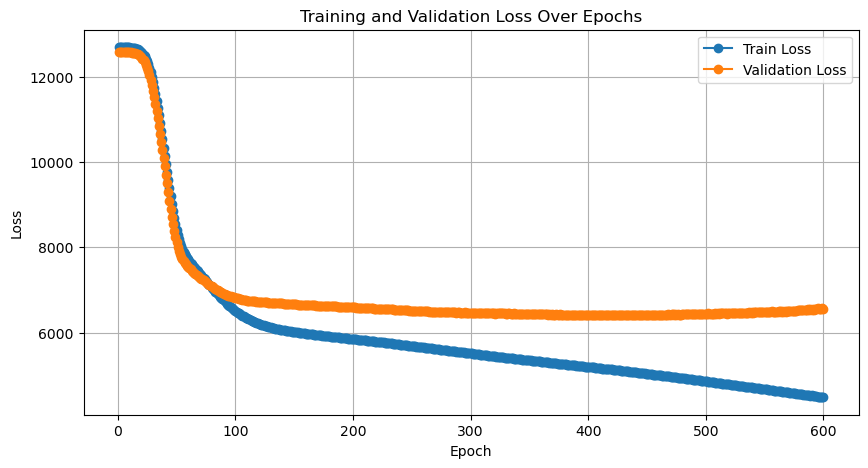

In [397]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(df_metrics['Epoch'], df_metrics['Train Loss'], label='Train Loss', marker='o')
ax.plot(df_metrics['Epoch'], df_metrics['Validation Loss'], label='Validation Loss', marker='o')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss Over Epochs')
ax.legend()
ax.grid()
plt.show()

## 1.8 Evaluate Model on Test-Set

In [398]:
# Evaluation function
def evaluate_model(model, data_loader, criterion):
    
    predictions = []
    actuals = []
    running_loss = 0.0

    model.eval()
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs, targets.float())
            running_loss += loss.item() * inputs.size(0)
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(targets.squeeze().tolist())
    
    avg_loss = running_loss / len(data_loader.dataset)

    return actuals, predictions, avg_loss

In [399]:
# Evaluate on test set
actuals, predictions, avg_loss = evaluate_model(model, test_loader, loss_function)
print(f"Test Loss: {avg_loss:.4f}")

Test Loss: 5891.8789


In [400]:
print(len(actuals), len(predictions))
# actuals
predictions

641 641


[1794.220947265625,
 5495.74169921875,
 7380.89306640625,
 6822.91650390625,
 1881.4833984375,
 22932.275390625,
 9687.8115234375,
 4423.92529296875,
 8187.8427734375,
 2459.00341796875,
 34879.890625,
 14842.56640625,
 14480.953125,
 53766.3359375,
 4530.91357421875,
 6502.33740234375,
 12240.33984375,
 1325.71435546875,
 5825.171875,
 31617.611328125,
 9088.9755859375,
 12294.158203125,
 16759.001953125,
 4490.630859375,
 6255.61279296875,
 23008.25,
 6665.931640625,
 1081.3253173828125,
 2661.417724609375,
 19449.708984375,
 31981.583984375,
 13876.2109375,
 11541.033203125,
 3073.873046875,
 1684.48681640625,
 9492.7080078125,
 3751.603271484375,
 2867.845703125,
 2501.77099609375,
 5893.8583984375,
 4661.3671875,
 8743.234375,
 6328.392578125,
 2044.177978515625,
 445.24395751953125,
 2383.10009765625,
 22017.048828125,
 2119.9091796875,
 1657.5615234375,
 4634.79296875,
 15336.220703125,
 14008.826171875,
 15318.876953125,
 862.9815063476562,
 6487.20947265625,
 12317.912109375,


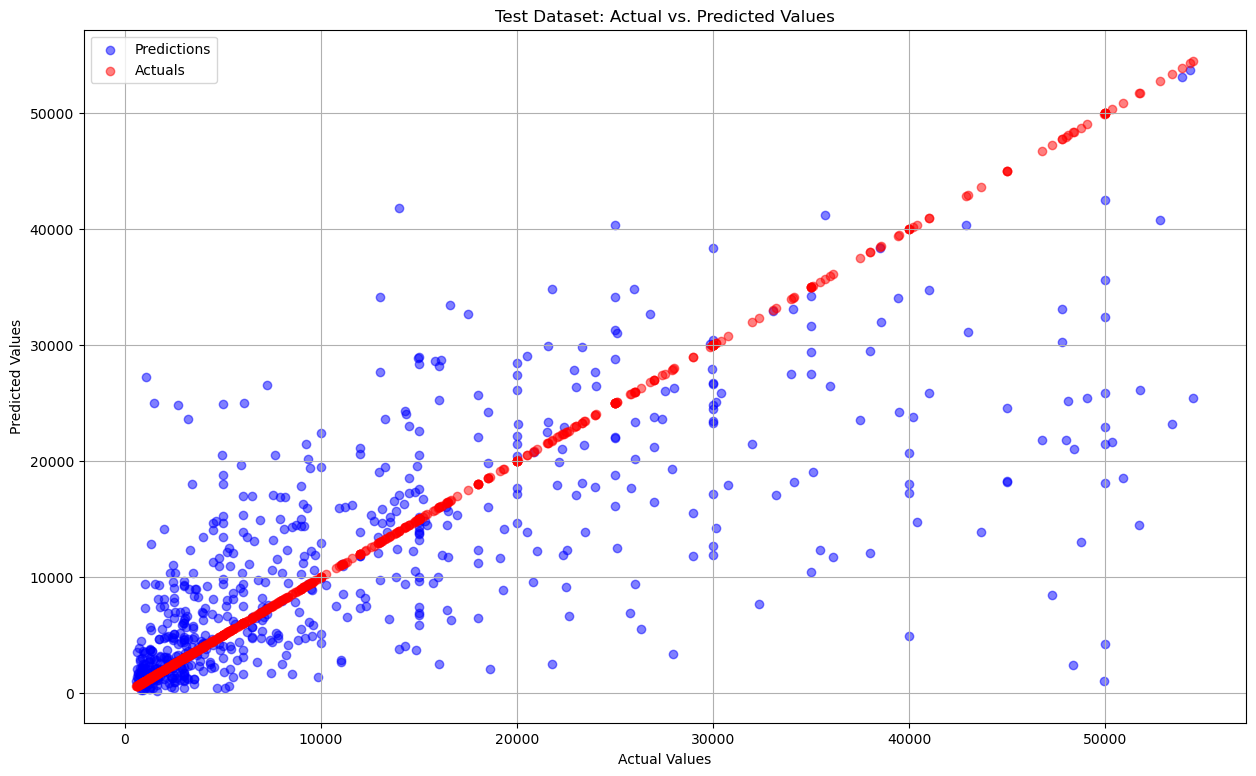

In [401]:
# Plot actual vs. predicted values
fig, ax = plt.subplots(1,1, figsize=(15,9))
ax.scatter(actuals, predictions, color='blue', alpha=0.5, label='Predictions')
ax.scatter(actuals, actuals, color='red', alpha=0.5, label='Actuals')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Test Dataset: Actual vs. Predicted Values')
ax.legend()
ax.grid(True)
plt.show()

In [403]:
def calculate_rmse(pred, label):
    pred = np.array(pred)
    label = np.array(label)
    return np.sqrt(np.mean((pred - label) ** 2))

rmse = calculate_rmse(predictions, actuals)
print(f"Root Mean Squared Error: {rmse}")


Root Mean Squared Error: 9466.979804290897


In [404]:
def calculate_mape(pred, label):
    pred = np.array(pred)
    label = np.array(label)
    return np.mean(np.abs((label - pred) / label)) * 100

mape = calculate_mape(predictions, actuals)
print(f"Mean Absolute Percentage Error: {mape:.2f}%")


Mean Absolute Percentage Error: 80.97%
